In [1]:
import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)

In [2]:
import math
from statistics import mean
import yaml
import argparse
import copy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from data.trainloader import MyDataset
from data.process_data import Dataset
from models.NCF import NCF
from models.GMF import GMF
from models.NeuMF import NeuMF
import matplotlib.pyplot as plt
import pickle
from main import get_train_instances, validate, training

In [3]:
# function conduct one experiment on models with configs & num negatives
def experiment(dataset, models, configs, num_negatives, device):

    train, testRatings, testNegatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
    num_users, num_items = train.shape

    # load model
    if models == 'NCF':
        model = NCF(num_users, num_items, configs["mlp_emb_size"], configs["layers"])
    if models == 'GMF':
        model = GMF(num_users, num_items, configs["gmf_emb_size"])
    if models == 'NeuMF':
        model = NeuMF(num_users, num_items, configs["mlp_emb_size"], configs["gmf_emb_size"], configs["layers"])
    model = model.to(device)
    print(model)

    # define the loss function & optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=configs["learning_rate"], weight_decay=configs["l2_reg"])

    # run through epochs, track loss/hr/ndcg history and best value
    loss_history, hr_history, ndcg_history = [], [], []
    best_hr, best_ndcg, best_epoch = 0.0, 0.0, 0
    for epoch in range(configs["epochs"]):
        # training
        user_input, item_input, labels = get_train_instances(train, num_negatives, num_users)
        ds = MyDataset(user_tensor=torch.LongTensor(user_input), item_tensor=torch.LongTensor(item_input), label_tensor=torch.LongTensor(labels))
        train_loader = DataLoader(ds, batch_size=configs["batch_size"], shuffle=True)
        loss = training(epoch, train_loader, model, optimizer, criterion, device)

        # validation
        hr, ndcg = validate(epoch, testRatings, testNegatives, model, device, num_users)

        # update history and best value
        loss_history.append(loss)
        hr_history.append(hr)
        ndcg_history.append(ndcg)

        print(("### [{5}] ### Validation Result Epoch: {0} HitRate: {1} Best HitRate: {2} NDCG: {3} Best NDCG: {4}").format(epoch, hr, best_hr, ndcg,\
         best_ndcg, num_negatives))
        if hr > best_hr:
            best_hr = hr
            best_ndcg = ndcg
            best_epoch = epoch

    print("### [{3}] ### Finish ### Best Epoch: {0} Best HitRate: {1} Best Ndcg: {2}".format(best_epoch, best_hr, best_ndcg, num_negatives))
    return best_hr, best_ndcg


In [4]:
dataset = Dataset("./data/ml-1m")

# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("You are using device: %s" % device)

You are using device: cuda:0


In [ ]:
# NCF experiment

# configs
configs = {
    "batch_size": 256,
    "learning_rate": 0.001,
    "epochs": 30,
    "mlp_emb_size": 64,
    "gmf_emb_size" : 0,
    "layers": [64,32,16,8],
    "l2_reg": 0.000001
}

# NCF
ncf_hrs = [0] * 10
ncf_ndcgs = [0] * 10
for i in range(1, 11):
    hr, ndcg = experiment(dataset, "NCF", configs, i, device)
    ncf_hrs[i-1] = hr
    ncf_ndcgs[i-1] = ndcg

In [ ]:
# GMF experiment

# configs
configs = {
    "batch_size": 512,
    "learning_rate": 0.003,
    "epochs": 30,
    "mlp_emb_size": 0,
    "gmf_emb_size" : 32,
    "layers": [],
    "l2_reg": 0.0000001
}

# GMF
gmf_hrs = [0] * 10
gmf_ndcgs = [0] * 10
for i in range(1, 11):
    hr, ndcg = experiment(dataset, "GMF", configs, i, device)
    gmf_hrs[i-1] = hr
    gmf_ndcgs[i-1] = ndcg

In [ ]:
# NeuMF experiment

# configs
configs = {
    "batch_size": 512,
    "learning_rate": 0.005,
    "epochs": 30,
    "mlp_emb_size": 64,
    "gmf_emb_size" : 32,
    "layers": [64,32,16,8],
    "l2_reg": 0.0000001

}

# NeuMF
neumf_hrs = [0] * 10
neumf_ndcgs = [0] * 10
for i in range(1, 11):
    hr, ndcg = experiment(dataset, "NeuMF", configs, i, device)
    neumf_hrs[i-1] = hr
    neumf_ndcgs[i-1] = ndcg

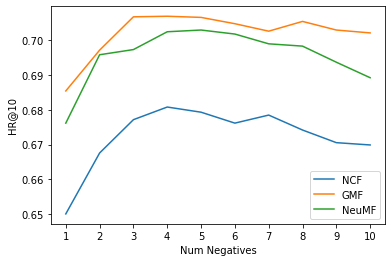

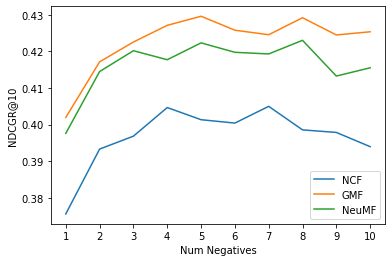

<Figure size 432x288 with 0 Axes>

In [7]:
xticks = [*range(1, 11, 1)]
# generate plots
plt.plot(xticks, ncf_hrs, label='NCF')
plt.plot(xticks, gmf_hrs, label='GMF')
plt.plot(xticks, neumf_hrs, label='NeuMF')
plt.xlabel('Num Negatives')
plt.ylabel('HR@10')
plt.xticks(xticks)
plt.legend()
plt.show()
plt.clf()

plt.plot(xticks, ncf_ndcgs, label='NCF')
plt.plot(xticks, gmf_ndcgs, label='GMF')
plt.plot(xticks, neumf_ndcgs, label='NeuMF')
plt.xlabel('Num Negatives')
plt.ylabel('NDCGR@10')
plt.xticks(xticks)
plt.legend()
plt.show()
plt.clf()